<img src="../assets/sujet.PNG" alt="Girl in a jacket" width="800" height="500">

<hr style="background-color: #0e8388; height:2px;">

In [69]:
!pip install numba==0.55.1

  Using cached numba-0.55.1-cp39-cp39-win_amd64.whl.metadata (3.3 kB)
  Using cached llvmlite-0.38.1-cp39-cp39-win_amd64.whl.metadata (4.7 kB)
  Using cached numpy-1.21.6-cp39-cp39-win_amd64.whl.metadata (2.2 kB)
Using cached numba-0.55.1-cp39-cp39-win_amd64.whl (2.4 MB)
   ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/23.2 MB ? eta -:--:--
    ------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pywavelets 1.6.0 requires numpy<3,>=1.22.4, but you have numpy 1.21.6 which is incompatible.
scipy 1.13.1 requires numpy<2.3,>=1.22.4, but you have numpy 1.21.6 which is incompatible.
statsmodels 0.14.2 requires numpy>=1.22.3, but you have numpy 1.21.6 which is incompatible.
ydata-profiling 4.9.0 requires numba<1,>=0.56.0, but you have numba 0.55.1 which is incompatible.


# Import librairies

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import mlflow
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.express as px
import ppscore as pps
import seaborn as sns
from loguru import logger
from mlflow.models import infer_signature
from sklearn import set_config
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import (r2_score,
                             root_mean_squared_error,
                             mean_absolute_percentage_error,
                             mean_absolute_error,
                             max_error,
                            )
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from ydata_profiling import ProfileReport
from yellowbrick.regressor import PredictionError, ResidualsPlot

sys.path.append(str(Path.cwd().parent))
from settings.params import MODEL_PARAMS, SEED
from src.make_dataset import load_data, merge_data


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
set_config(display="diagram", print_changed_only=False)  # display sklearn pipeline as diagram

C:\Users\stg_danfa75294\Documents\customer segmentation\.venv\lib\site-packages\mlflow\models\utils.py:39: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.6)
  from scipy.sparse import csc_matrix, csr_matrix
C:\Users\stg_danfa75294\Documents\customer segmentation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Settings

In [3]:
# Set logging format
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

# current data
CURRENT_DATE = pendulum.now(tz="UTC")

# target name definition
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]
logger.info(f"Target name: {TARGET_NAME}")


# directories
PROJECT_DIR = Path.cwd().parent
REPORTS_DIR = Path(PROJECT_DIR, "reports")

logger.info(f"\nProject directory: {PROJECT_DIR} \nReports dir: {REPORTS_DIR}")

2024-08-05 15:32:06.296 | INFO     | __main__:<module>:10 - Target name: price
2024-08-05 15:32:06.297 | INFO     | __main__:<module>:17 - 
Project directory: C:\Users\stg_danfa75294\Documents\customer segmentation 
Reports dir: C:\Users\stg_danfa75294\Documents\customer segmentation\reports


In [4]:
MODEL_PARAMS

{'TARGET_NAME': 'price',
 'MIN_COMPLETION_RATE': 0.9,
 'MIN_PPS': 0.1,
 'DEFAULT_FEATURE_NAMES': ['customer_zip_code_prefix',
  'customer_city',
  'customer_state',
  'order_status',
  'price',
  'freight_value',
  'payment_type',
  'payment_installments',
  'payment_value',
  'product_category',
  'order_item_id',
  'order_purchase_year',
  'order_purchase_month',
  'order_purchase_day',
  'order_purchase_hour'],
 'TEST_SIZE': 0.25}

# Data collection

In [5]:
# List of customers data
olist_customers_data = load_data(dataset_name="olist_customers_dataset.csv")
logger.info(f"olist_customers_data_shape  {olist_customers_data.shape}")

# List of oder items data
olist_order_items_data = load_data(dataset_name="olist_order_items_dataset.csv")
logger.info(f"olist_order_items_data_shape  {olist_order_items_data.shape}")

# List of orders payments data
olist_order_payments_data = load_data(dataset_name="olist_order_payments_dataset.csv")
logger.info(f"olist_order_payments_data_shape  {olist_order_payments_data.shape}")

# List of orders data
olist_orders_data = load_data(dataset_name="olist_orders_dataset.csv")
logger.info(f"olist_orders_data_shape  {olist_orders_data.shape}")

# List of sellers data
olist_sellers_data = load_data(dataset_name="olist_sellers_dataset.csv")
logger.info(f"olist_sellers_data_shape  {olist_sellers_data.shape}")

# List of product category data
product_category_name_translation = load_data(dataset_name="product_category_name_translation.csv")
logger.info(f"product_category_name_translation_shape  {product_category_name_translation.shape}")

# List of sellers data
olist_geolocation_data = load_data(dataset_name="olist_geolocation_dataset.csv")
logger.info(f"olist_geolocation_data_shape  {olist_geolocation_data.shape}")

# List of product category data
olist_order_reviews_data = load_data(dataset_name="olist_order_reviews_dataset.csv")
logger.info(f"olist_order_reviews_data_shape  {olist_order_reviews_data.shape}")

# List of product category data
olist_products_data = load_data(dataset_name="olist_products_dataset.csv")
logger.info(f"olist_products_data_shape  {olist_products_data.shape}")

2024-08-05 15:32:07.402 | INFO     | src.make_dataset:load_data:25 - Dataset lo load: olist_customers_dataset.csv
2024-08-05 15:32:07.403 | INFO     | __main__:<module>:3 - olist_customers_data_shape  (99441, 5)
2024-08-05 15:32:07.809 | INFO     | src.make_dataset:load_data:25 - Dataset lo load: olist_order_items_dataset.csv
2024-08-05 15:32:07.810 | INFO     | __main__:<module>:7 - olist_order_items_data_shape  (112650, 7)
2024-08-05 15:32:07.982 | INFO     | src.make_dataset:load_data:25 - Dataset lo load: olist_order_payments_dataset.csv
2024-08-05 15:32:07.983 | INFO     | __main__:<module>:11 - olist_order_payments_data_shape  (103886, 5)
2024-08-05 15:32:08.577 | INFO     | src.make_dataset:load_data:25 - Dataset lo load: olist_orders_dataset.csv
2024-08-05 15:32:08.578 | INFO     | __main__:<module>:15 - olist_orders_data_shape  (99441, 8)
2024-08-05 15:32:08.589 | INFO     | src.make_dataset:load_data:25 - Dataset lo load: olist_sellers_dataset.csv
2024-08-05 15:32:08.591 | IN

In [6]:
olist_customers_data.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [7]:
olist_order_items_data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
olist_order_payments_data.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [9]:
olist_orders_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [10]:
olist_sellers_data.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [11]:
product_category_name_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [12]:
olist_geolocation_data.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [13]:
dataframes = {'customers': olist_customers_data,
              'items': olist_order_items_data, 
              'payments': olist_order_payments_data, 
              'orders': olist_orders_data, 
              'products': olist_products_data, 
              'sellers': olist_sellers_data, 
              'categories': product_category_name_translation}
for i, j in dataframes.items():
    logger.info(f'{i:12s} dataframe: {str(len(j)):7s} rows \n')

2024-08-05 15:32:12.228 | INFO     | __main__:<module>:9 - customers    dataframe: 99441   rows 

2024-08-05 15:32:12.230 | INFO     | __main__:<module>:9 - items        dataframe: 112650  rows 

2024-08-05 15:32:12.231 | INFO     | __main__:<module>:9 - payments     dataframe: 103886  rows 

2024-08-05 15:32:12.232 | INFO     | __main__:<module>:9 - orders       dataframe: 99441   rows 

2024-08-05 15:32:12.234 | INFO     | __main__:<module>:9 - products     dataframe: 32951   rows 

2024-08-05 15:32:12.236 | INFO     | __main__:<module>:9 - sellers      dataframe: 3095    rows 

2024-08-05 15:32:12.237 | INFO     | __main__:<module>:9 - categories   dataframe: 71      rows 



In [14]:
#Checking and removing duplicates
dfs = {'customers': olist_customers_data, 'order_items': olist_order_items_data, 'payments': olist_order_payments_data, 'reviews': olist_order_payments_data, 'orders': olist_orders_data, 'products': olist_products_data}

def check_and_remove_duplicates(df, name):
    duplicates = df[df.duplicated()]
    print(f"Number of duplicate rows in {name}: {duplicates.shape[0]}")
    df_no_duplicates = df.drop_duplicates()
    return df_no_duplicates

for name, df in dfs.items():
    dfs[name] = check_and_remove_duplicates(df, name)
    

Number of duplicate rows in customers: 0
Number of duplicate rows in order_items: 0
Number of duplicate rows in payments: 0
Number of duplicate rows in reviews: 0
Number of duplicate rows in orders: 0
Number of duplicate rows in products: 0


In [15]:
#products_df contains 73 unique categories, while categories_df contains 71: that's why we use left, 
# for missing categories we keep the category name in Portuguese.
olist_products_data = pd.merge(olist_products_data, product_category_name_translation, on='product_category_name', how='left')
# Delete 'product_category_name' column
del olist_products_data['product_category_name']
# Delete  the categories_df dataframe
del product_category_name_translation
# Rename the column
olist_products_data.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)


In [16]:
data = pd.merge(olist_customers_data,olist_orders_data,  on='customer_id')
data = merge_data(data, olist_order_items_data, 'order_id')
#data = merge_data(data, olist_orders_data, 'order_id')
data = merge_data(data, olist_order_payments_data, 'order_id')
data = merge_data(data, olist_products_data, 'product_id')
data = merge_data(data,olist_sellers_data, 'seller_id')


data.head()


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,1.0,credit_card,2.0,146.87,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577.0,itaquaquecetuba,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1.0,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,1.0,credit_card,8.0,335.48,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,housewares,88303.0,itajai,SC
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1.0,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,1.0,credit_card,7.0,157.73,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,office_furniture,8577.0,itaquaquecetuba,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1.0,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,1.0,credit_card,1.0,173.30,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,office_furniture,8577.0,itaquaquecetuba,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1.0,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,1.0,credit_card,8.0,252.25,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,home_confort,14940.0,ibitinga,SP


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    118434 non-null  object 
 1   customer_unique_id             118434 non-null  object 
 2   customer_zip_code_prefix       118434 non-null  int64  
 3   customer_city                  118434 non-null  object 
 4   customer_state                 118434 non-null  object 
 5   order_id                       118434 non-null  object 
 6   order_status                   118434 non-null  object 
 7   order_purchase_timestamp       118434 non-null  object 
 8   order_approved_at              118258 non-null  object 
 9   order_delivered_carrier_date   116360 non-null  object 
 10  order_delivered_customer_date  115037 non-null  object 
 11  order_estimated_delivery_date  118434 non-null  object 
 12  order_item_id                 

In [18]:
customers = olist_customers_data['customer_unique_id'].nunique()
orders = olist_orders_data.order_id.nunique()
print("number of customers:", customers)
print("number of orders:   ", orders)
print(f"number of orders per cusotmer: {orders / customers:.2f}")

number of customers: 96096
number of orders:    99441
number of orders per cusotmer: 1.03


In [19]:
data.groupby('product_category')['customer_id'].nunique()


product_category
agro_industry_and_commerce                  182
air_conditioning                            253
art                                         202
arts_and_craftmanship                        23
audio                                       350
auto                                       3897
baby                                       2885
bed_bath_table                             9417
books_general_interest                      512
books_imported                               53
books_technical                             260
cds_dvds_musicals                            12
christmas_supplies                          128
cine_photo                                   65
computers                                   181
computers_accessories                      6689
consoles_games                             1062
construction_tools_construction             748
construction_tools_lights                   244
construction_tools_safety                   167
cool_stuff             

In [20]:
from scipy import stats
def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column'] = summary['index']
    summary = summary[['Column','dtypes']]
    summary['# Missing'] = df.isnull().sum().values    
    summary['# Unique'] = df.nunique().values
    summary['Example'] = df.loc[0].values

    for name in summary['Column'].value_counts().index:
        summary.loc[summary['Column'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary
    
df_summary(data)

Dataset Shape: (118434, 33)


,Column,dtypes,# Missing,# Unique,Example,Entropy
0,customer_id,object,0,99441,06b8999e2fba1a1fbc88172c00ba8bc7,16.46
1,customer_unique_id,object,0,96096,861eff4711a542e4b93843c6dd7febb0,16.39
2,customer_zip_code_prefix,int64,0,14994,14409,13.11
3,customer_city,object,0,4119,franca,8.13
4,customer_state,object,0,27,SP,3.07
5,order_id,object,0,99441,00e7ee1b050b8499577073aeb2a297a1,16.46
6,order_status,object,0,8,delivered,0.25
7,order_purchase_timestamp,object,0,98875,2017-05-16 15:05:35,16.45
8,order_approved_at,object,176,90733,2017-05-16 15:22:12,16.28
9,order_delivered_carrier_date,object,2074,81018,2017-05-23 10:47:57,16.03


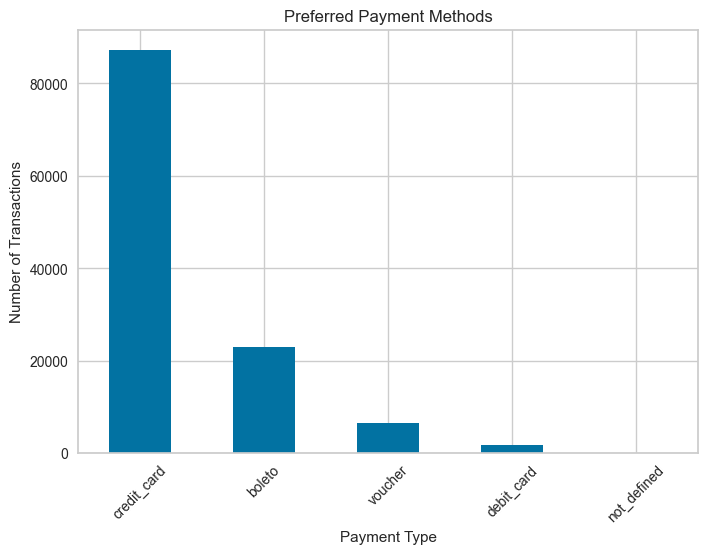

In [21]:
# Plotting preferred payment methods
payment_counts = data['payment_type'].value_counts()
payment_counts.plot(kind='bar')
plt.title('Preferred Payment Methods')
plt.xlabel('Payment Type')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Compter les valeurs nulles pour chaque colonne
null_counts = data.isnull().sum()

null_counts

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
order_estimated_delivery_date       0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_name_lenght              2528
product_description_lenght       2528
product_photos_qty               2528
product_weight_g                  850
product_leng

In [23]:
# Compter les valeurs nulles pour chaque colonne
na_counts = data.isna().sum()

na_counts

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_carrier_date     2074
order_delivered_customer_date    3397
order_estimated_delivery_date       0
order_item_id                     830
product_id                        830
seller_id                         830
shipping_limit_date               830
price                             830
freight_value                     830
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_name_lenght              2528
product_description_lenght       2528
product_photos_qty               2528
product_weight_g                  850
product_leng

In [24]:
# Cast some columns to str
"""data = data.astype({"YearBuilt": str,
                    "YearRemodAdd": str,
                    "GarageYrBlt": str,
                     "MoSold": str,
                     "YrSold": str
                    })"""

'data = data.astype({"YearBuilt": str,\n                    "YearRemodAdd": str,\n                    "GarageYrBlt": str,\n                     "MoSold": str,\n                     "YrSold": str\n                    })'

In [25]:
data.describe(include="all", datetime_is_numeric=True)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
count,118434,118434,118434.000000,118434,118434,118434,118434,118434,118258,116360,115037,118434,117604.000000,117604,117604,117604,117604.000000,117604.000000,118431.000000,118431,118431.000000,118431.000000,115906.000000,115906.000000,115906.000000,117584.000000,117584.000000,117584.00000,117584.000000,115881,117604.000000,117604,117604
unique,99441,96096,NaN,4119,27,99441,8,98875,90733,81018,95664,459,NaN,32951,3095,93318,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,NaN,611,23
top,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,NaN,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-12-20 00:00:00,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,4a3ca9315b744ce9f8e9374361493884,2017-08-14 20:43:31,NaN,NaN,NaN,credit_card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bed_bath_table,NaN,sao paulo,SP
freq,63,75,NaN,18738,49967,63,115038,63,63,63,63,656,NaN,536,2133,63,NaN,NaN,NaN,87286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11823,NaN,29157,83854
mean,NaN,NaN,35034.264392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.195920,NaN,NaN,NaN,120.822849,20.045551,1.094207,NaN,2.937398,172.849395,48.767208,786.957302,2.207849,2114.281067,30.256872,16.63029,23.068394,NaN,24442.886483,NaN,NaN
std,NaN,NaN,29819.290218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.697721,NaN,NaN,NaN,184.477367,15.861351,0.728290,NaN,2.774164,268.259831,10.035162,653.029009,1.719519,3788.754048,16.190874,13.45878,11.748372,NaN,27573.802989,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000,1.000000,NaN,0.000000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.00000,6.000000,NaN,1001.000000,NaN,NaN
25%,NaN,NaN,11310.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000,1.000000,NaN,1.000000,60.860000,42.000000,347.000000,1.000000,300.000000,18.000000,8.00000,15.000000,NaN,6429.000000,NaN,NaN
50%,NaN,NaN,24240.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,74.900000,16.290000,1.000000,NaN,2.000000,108.200000,52.000000,601.000000,1.000000,700.000000,25.000000,13.00000,20.000000,NaN,13660.000000,NaN,NaN
75%,NaN,NaN,58464.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,134.900000,21.190000,1.000000,NaN,4.000000,189.245000,57.000000,985.000000,3.000000,1800.000000,38.000000,20.00000,30.000000,NaN,28035.000000,NaN,NaN


# EDA: Exploratory Data Analysis

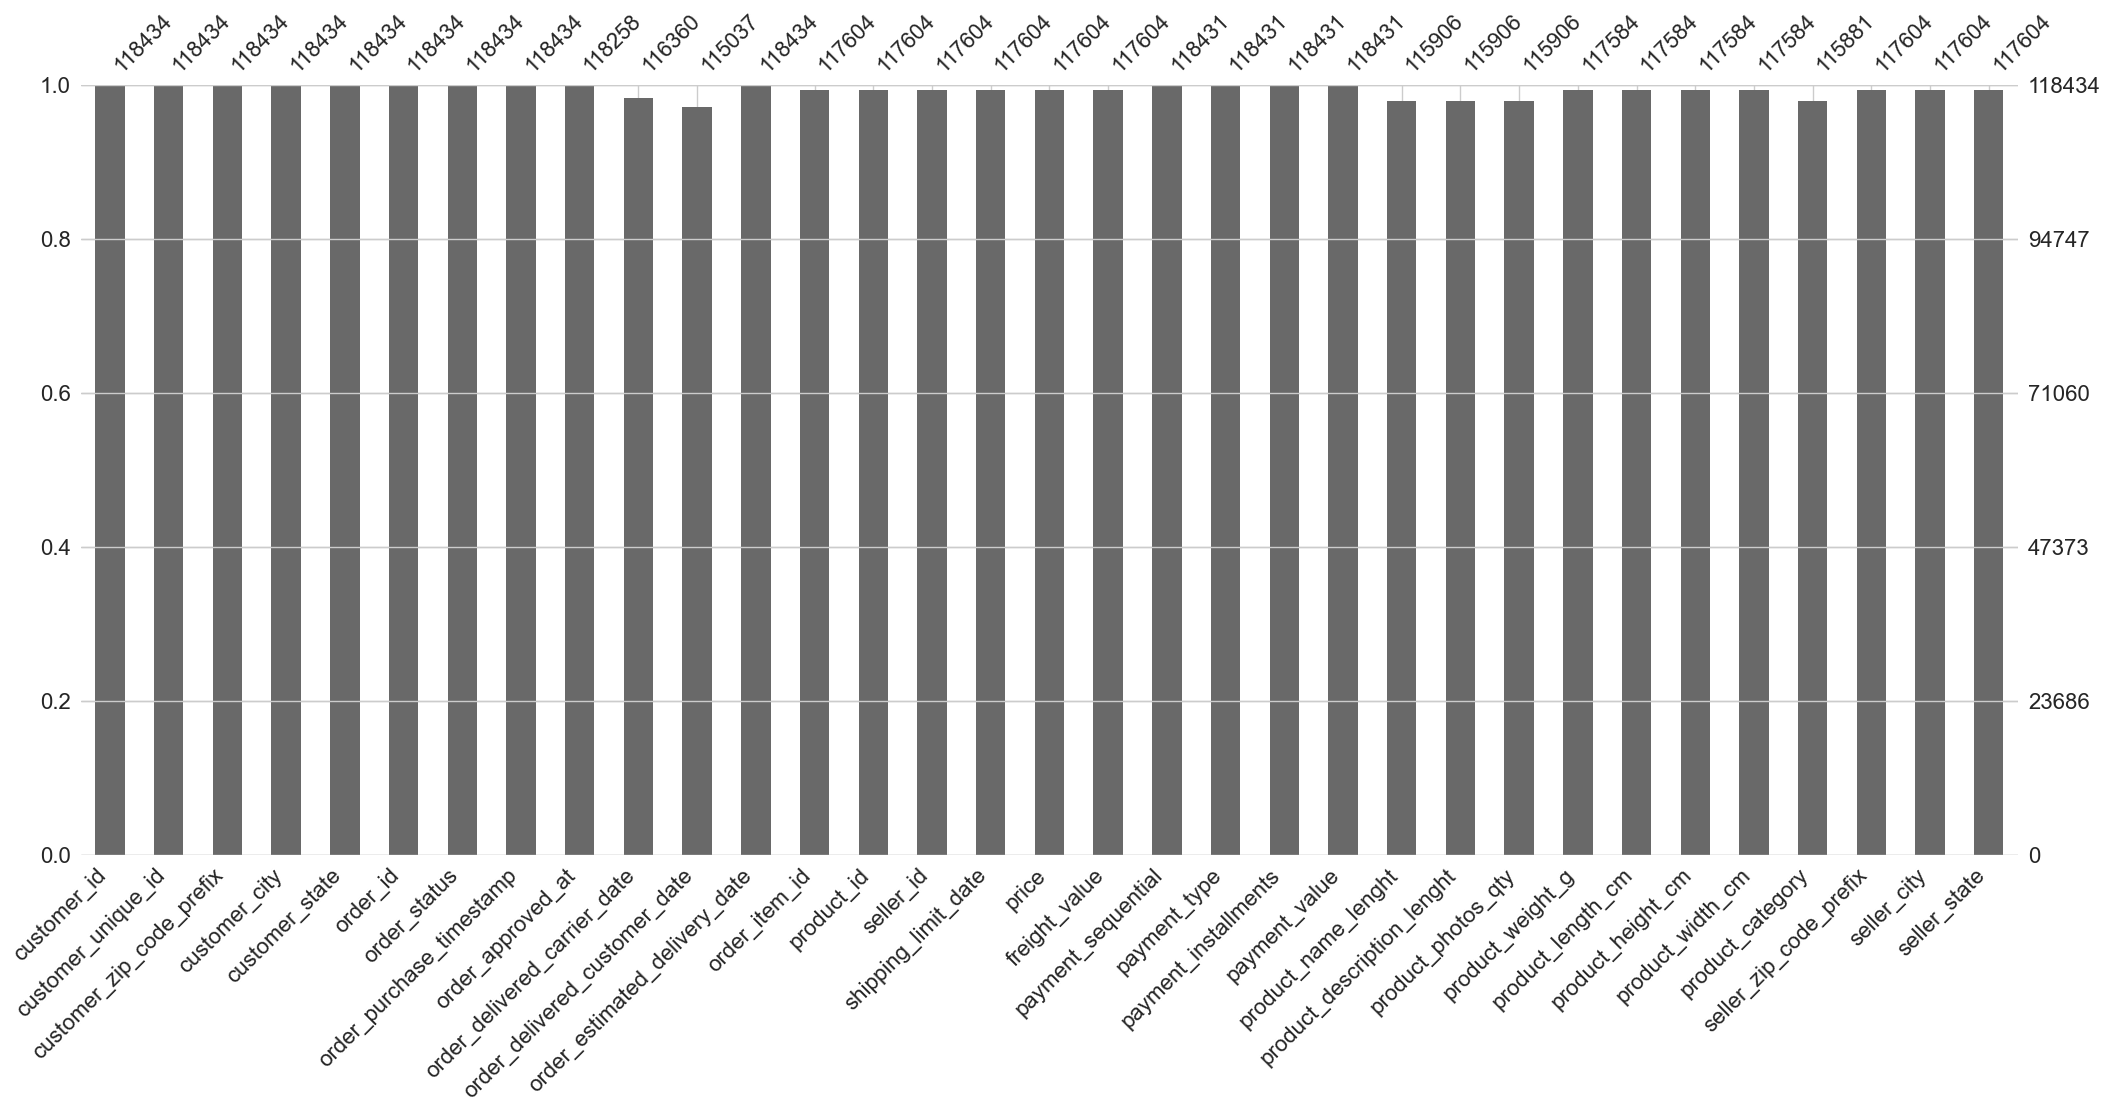

In [26]:
# barplot for missing value rate
msno.bar(data,
         filter="top",
         p=MODEL_PARAMS["MIN_COMPLETION_RATE"],
        );

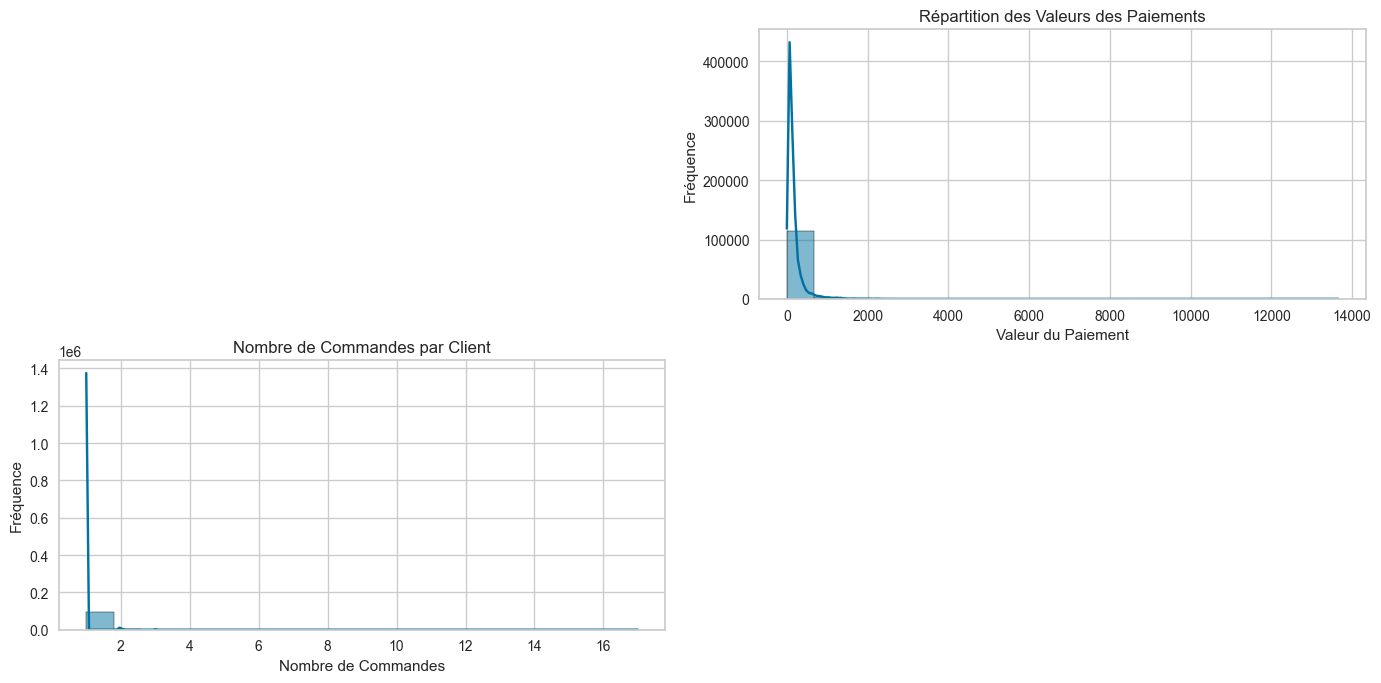

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer la taille des graphiques
plt.figure(figsize=(14, 7))



# Répartition des Valeurs des Paiements
plt.subplot(2, 2, 2)
sns.histplot(data['payment_value'], bins=20, kde=True)
plt.title('Répartition des Valeurs des Paiements')
plt.xlabel('Valeur du Paiement')
plt.ylabel('Fréquence')

# Nombre de Commandes par Client
orders_per_customer = data.groupby('customer_unique_id')['order_id'].nunique()
plt.subplot(2, 2, 3)
sns.histplot(orders_per_customer, bins=20, kde=True)
plt.title('Nombre de Commandes par Client')
plt.xlabel('Nombre de Commandes')
plt.ylabel('Fréquence')




plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='state'>

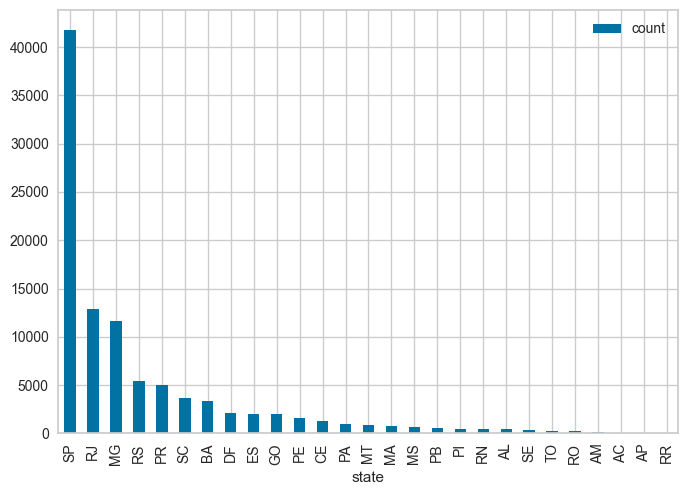

In [28]:
customer_location = data.groupby('customer_state')['customer_id'].nunique().reset_index()
customer_location.columns = ['state', 'count']
customer_location = customer_location.sort_values(by='count', ascending=False)

customer_location.plot(kind="bar", x="state", y="count")

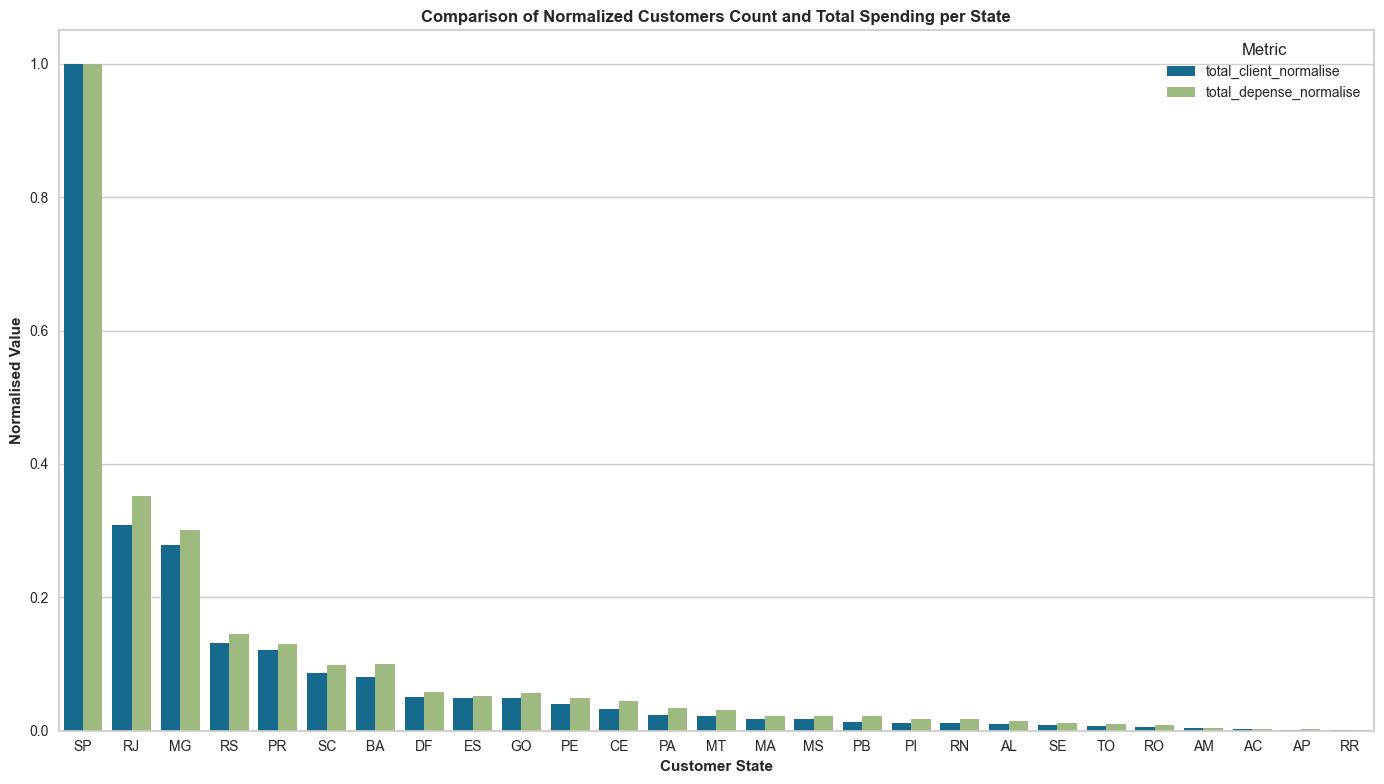

In [29]:
total_spending_per_state = data.groupby('customer_state')['price'].sum().reset_index()
total_spending_per_state.columns = ['state', 'total_spending']

merged_df = pd.merge(customer_location, total_spending_per_state, on='state')

merged_df['total_client_normalise'] = merged_df['count'] / merged_df['count'].max()
merged_df['total_depense_normalise'] = merged_df['total_spending'] / merged_df['total_spending'].max()

melted_df = pd.melt(merged_df, id_vars=['state'], value_vars=['total_client_normalise', 'total_depense_normalise'],
                    var_name='Metric', value_name='Value')

plt.figure(figsize=(14, 8))
sns.barplot(data=melted_df, x='state', y='Value', hue='Metric')

plt.xlabel('Customer State', fontweight='bold')
plt.ylabel('Normalised Value', fontweight='bold')
plt.title('Comparison of Normalized Customers Count and Total Spending per State', fontweight='bold')

plt.tight_layout()
plt.show()

In [30]:
data['customer_unique_id'].value_counts()

9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
8af7ac63b2efbcbd88e5b11505e8098a    29
569aa12b73b5f7edeaa6f2a01603e381    26
                                    ..
3a39beec85b79335793f32c2a2b8b944     1
0be6ef3e01097f10e3138b767c3d2406     1
996106e7fedbb633a950087922b13996     1
3bd36679c791dd432c81d931b3a86d32     1
84732c5050c01db9b23e19ba39899398     1
Name: customer_unique_id, Length: 96096, dtype: int64

In [31]:
# Analysing biggest customer

data[data['customer_unique_id'] == '9a736b248f67d166d2fbb006bcb877c3']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,seller_zip_code_prefix,seller_city,seller_state
22289,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,17.0,voucher,1.0,16.70,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22290,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,1.0,voucher,1.0,2.61,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22291,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,13.0,voucher,1.0,16.70,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22292,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,16.0,voucher,1.0,16.70,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22293,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,19.0,voucher,1.0,0.24,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22294,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,4.0,voucher,1.0,2.61,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22295,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,21.0,voucher,1.0,0.28,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres rios,RJ
22296,270c23a11d024a44c896d1894b261a83,9a736b248f67d166d2fbb006bcb877c3,3227,sao paulo,SP,895ab968e7bb0d5659d16cd74cd1650c,delivered,2017-08-08 20:26:31,2017-08-08 20:43:31,2017-08-10 11:58:14,2017-08-14 12:46:18,2017-08-30 00:00:00,1.0,ebf9bc6cd600eadd681384e3116fda85,822166ed1e47908f7cfb49946d03c726,2017-08-14 20:43:31,12.99,23.21,2.0,voucher,1.0,2.61,37.0,86.0,2.0,1300.0,50.0,9.0,41.0,bed_bath_table,25803.0,tres r

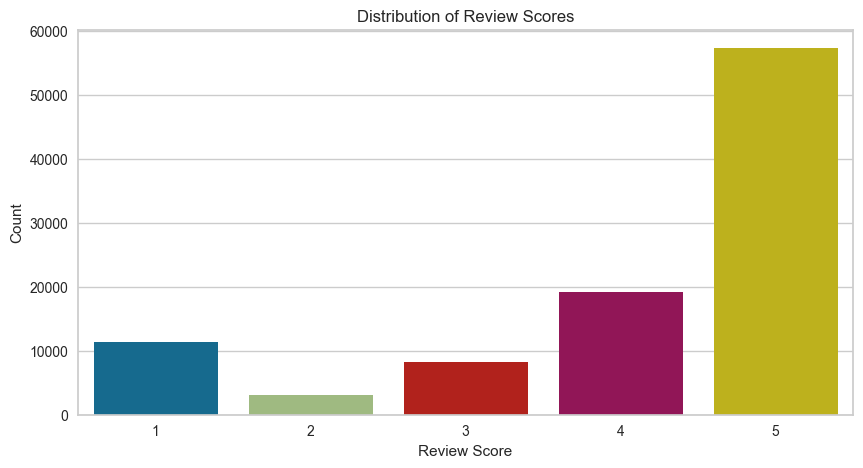

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(data=olist_order_reviews_data, x='review_score')
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()


Most reviews are positive (scores 4 and 5), indicating an overall positive customer experience.


## Target analysis

Todo:

    1- Ajouter un parameter dans le dictionnaire MODEL_PARAMS, appelé TARGET_NAME, qui prend la valeur "SalePrice"

    2- Construite l'histogramme de la variable cible en récupérant le nom depuis le dictionnaire MODEL_PARAMS
    3- Construire un 2e graphique sur la même ligne (variable target transformer en log)
    4- Continuer l'analyse exploratoire des variables  explicatives (quanti et quali)
    5- Faire une première sélection des variables explicatives à utiliser pour le modèle 
    6- Ajouter dans MODEL_PARAMS, un key appelé FEATURE_NAMES, qui stocke la liste des variables explicatives sélectionnées

In [33]:
MODEL_PARAMS["TARGET_NAME"]

'price'

In [34]:
# Target: stat description
data[TARGET_NAME].describe()

count    117604.000000
mean        120.822849
std         184.477367
min           0.850000
25%          39.900000
50%          74.900000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

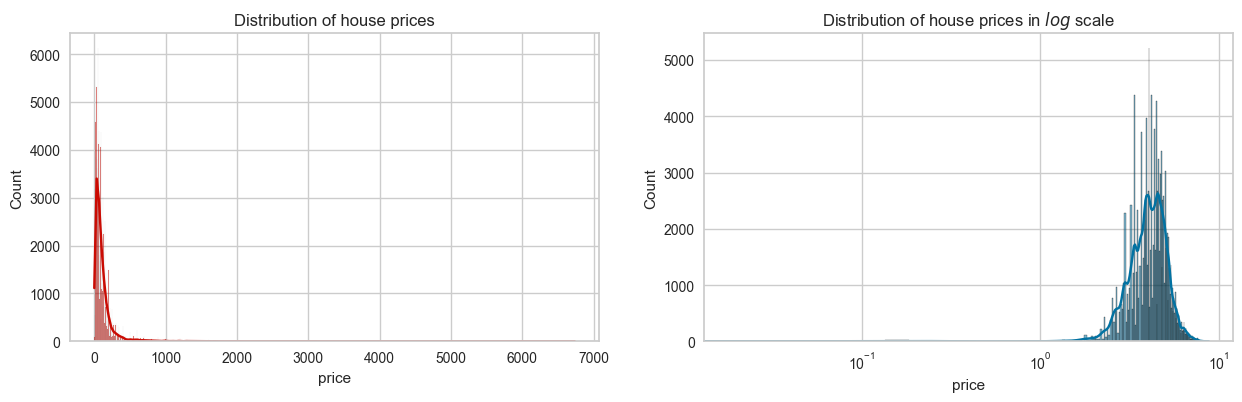

In [35]:
# Target distribution: raw vs log (box-cox transformation)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of house prices')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of house prices in $log$ scale')
axes[1].set_xscale('log');

In [36]:
# We 3 new columns
data['order_purchase_year'] = pd.to_datetime(data['order_purchase_timestamp']).dt.year
data['order_purchase_month'] = pd.to_datetime(data['order_purchase_timestamp']).dt.month
data['order_purchase_day'] = pd.to_datetime(data['order_purchase_timestamp']).dt.day
data['order_purchase_hour'] = pd.to_datetime(data['order_purchase_timestamp']).dt.hour

orders = data[['order_id', 'order_purchase_year', 'order_purchase_month']]
orders = orders.groupby(['order_purchase_month', 'order_purchase_year']).count().reset_index()
orders = orders.sort_values(by=['order_purchase_year', 'order_purchase_month'])
orders["period"] =  orders["order_purchase_month"].astype(str) + "/" + orders["order_purchase_year"].astype(str)
orders.head(3)

,order_purchase_month,order_purchase_year,order_id,period
16,9,2016,7,9/2016
19,10,2016,397,10/2016
23,12,2016,1,12/2016


## Feature engineering

In [37]:
# add age columns
"""data = data.assign(building_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearBuilt.astype(float),
                   remodel_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearRemodAdd.astype(float),
                   garage_age=lambda dfr: dfr.YrSold.astype(float) - dfr.GarageYrBlt.astype(float),
                  )
data.head()"""

'data = data.assign(building_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearBuilt.astype(float),\n                   remodel_age=lambda dfr: dfr.YrSold.astype(float) - dfr.YearRemodAdd.astype(float),\n                   garage_age=lambda dfr: dfr.YrSold.astype(float) - dfr.GarageYrBlt.astype(float),\n                  )\ndata.head()'

## Univariate analysis

In [38]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
logger.info(f"Categorical features:\n {sorted(categorical_features)}\n")

numerical_features = data.select_dtypes(include="number").drop(["order_item_id",TARGET_NAME], axis=1).columns
logger.info(f"Numerical features:\n {sorted(numerical_features)}")

2024-08-05 15:32:40.464 | INFO     | __main__:<module>:2 - Categorical features:
 ['customer_city', 'customer_id', 'customer_state', 'customer_unique_id', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_id', 'order_purchase_timestamp', 'order_status', 'payment_type', 'product_category', 'product_id', 'seller_city', 'seller_id', 'seller_state', 'shipping_limit_date']

2024-08-05 15:32:40.486 | INFO     | __main__:<module>:5 - Numerical features:
 ['customer_zip_code_prefix', 'freight_value', 'order_purchase_day', 'order_purchase_hour', 'order_purchase_month', 'order_purchase_year', 'payment_installments', 'payment_sequential', 'payment_value', 'product_description_lenght', 'product_height_cm', 'product_length_cm', 'product_name_lenght', 'product_photos_qty', 'product_weight_g', 'product_width_cm', 'seller_zip_code_prefix']


## Bivariate analysis

In [39]:
numeric_df = data[numerical_features.drop(['order_purchase_day', 'order_purchase_hour', 'order_purchase_month', 'order_purchase_year'])]
corr = numeric_df.corr()

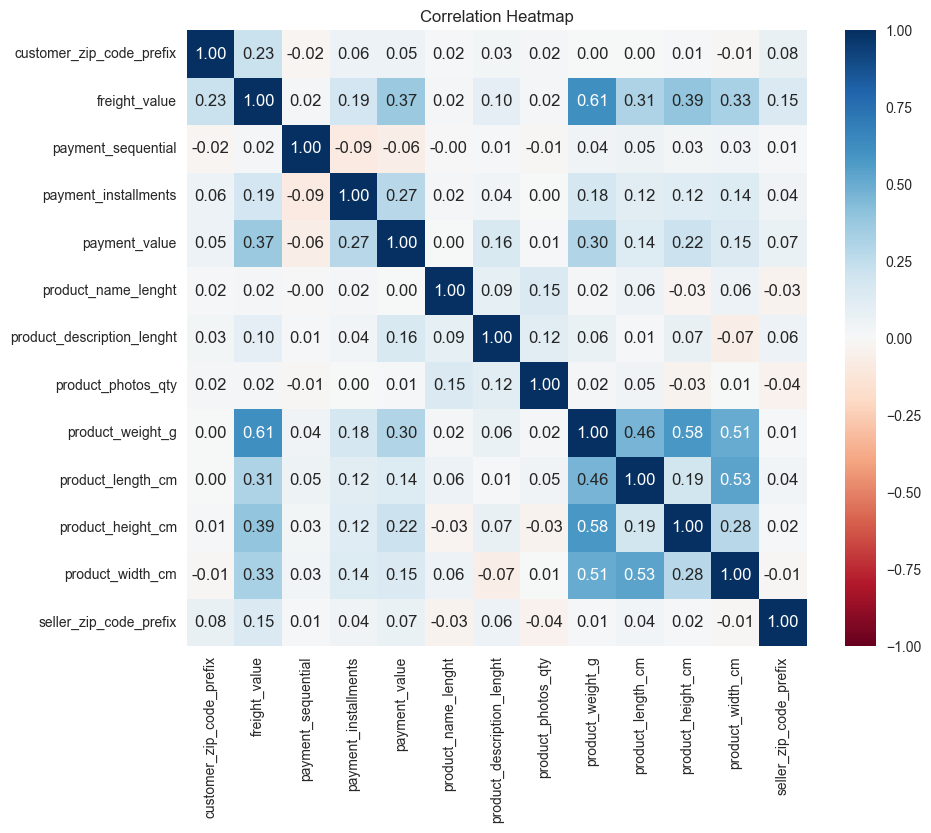

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='RdBu', norm=plt.Normalize(-1,1), annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

In [41]:
set(numerical_features)&set(MODEL_PARAMS["DEFAULT_FEATURE_NAMES"])

{'customer_zip_code_prefix',
 'freight_value',
 'order_purchase_day',
 'order_purchase_hour',
 'order_purchase_month',
 'order_purchase_year',
 'payment_installments',
 'payment_value'}

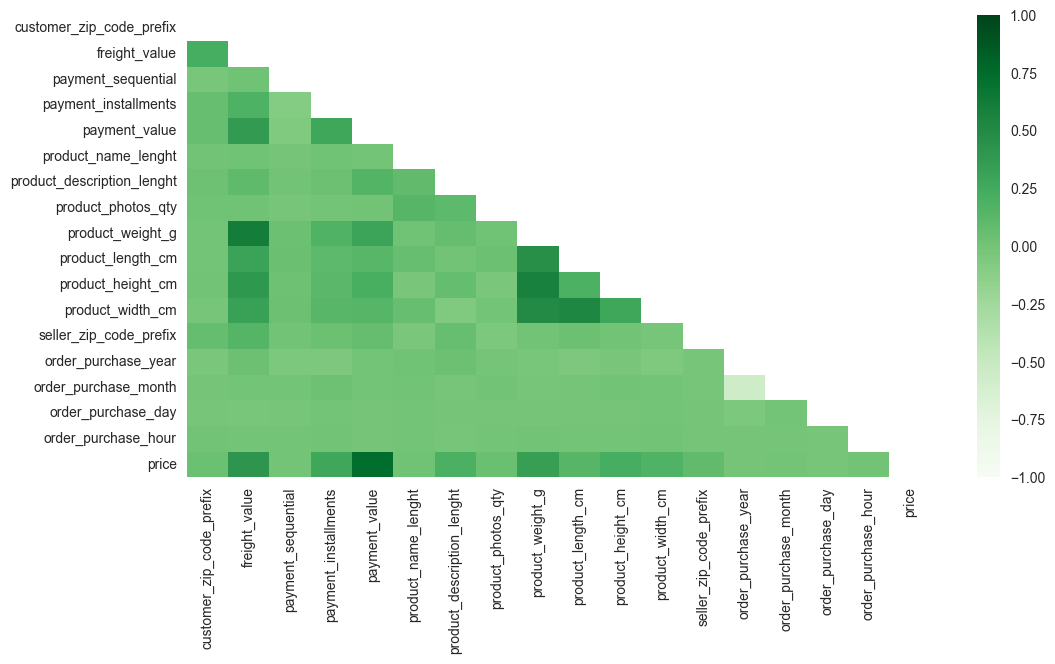

In [45]:
# correlation
num_correlation = data.loc[:, list(numerical_features) + [TARGET_NAME]].corr(method="pearson", numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
mask = np.triu(num_correlation)

plt.figure(figsize=(12, 6))
sns.heatmap(num_correlation, vmin=-1, vmax=1, annot=False, mask=mask, fmt='.2f', square=False, cmap="Greens");

## Data profiling

In [ ]:
# https://github.com/ydataai/ydata-profiling: générer le rapport des données avec ProfileReport
# generate report
profile = ProfileReport(data, title="Olist customer - Report")

# save report to html
profile.to_file(Path(REPORTS_DIR, "olist_customer_profiling.html"))

# Display the report in the notebook
# profile.to_notebook_iframe()

## Features selection

In [20]:
SEED

42

In [21]:
# Predictive Power Score (PPS) : https://github.com/8080labs/ppscore/
pps_predictors = pps.predictors(df=data.drop(["Id", "YrSold", "YearBuilt", "YearRemodAdd", "GarageYrBlt"], axis=1),
                                y=TARGET_NAME, output="df", random_seed=SEED)

In [22]:
pps_predictors

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,OverallQual,SalePrice,0.444021,regression,True,mean absolute error,55533.656164,30875.568225,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
1,Neighborhood,SalePrice,0.337573,regression,True,mean absolute error,55533.656164,36786.967628,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
2,GarageCars,SalePrice,0.298869,regression,True,mean absolute error,55533.656164,38936.361994,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
3,ExterQual,SalePrice,0.275945,regression,True,mean absolute error,55533.656164,40209.410056,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
4,BsmtQual,SalePrice,0.267740,regression,True,mean absolute error,55400.797611,40567.772895,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
5,KitchenQual,SalePrice,0.263696,regression,True,mean absolute error,55533.656164,40889.655962,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
6,building_age,SalePrice,0.192380,regression,True,mean absolute error,55533.656164,44850.101011,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
7,FullBath,SalePrice,0.192349,regression,True,mean absolute error,55533.656164,44851.838100,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
8,Alley,SalePrice,0.175269,regression,True,mean absolute error,33871.626374,27934.963987,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."
9,GarageArea,SalePrice,0.174296,regression,True,mean absolute error,55533.656164,45854.385436,"DecisionTreeRegressor(ccp_alpha=0.0, criterion..."


In [23]:
pps.__version__

'1.3.0'

In [24]:
# check if there are invalide pps scores in the output
pps_predictors.is_valid_score.value_counts()

True    78
Name: is_valid_score, dtype: int64

In [25]:
# get feature names
FEATURE_NAMES = pps_predictors.loc[pps_predictors.ppscore >= MODEL_PARAMS["MIN_PPS"], "x"].values
set(FEATURE_NAMES)

{'Alley',
 'BsmtQual',
 'ExterQual',
 'Foundation',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageFinish',
 'GarageType',
 'GrLivArea',
 'KitchenQual',
 'MSSubClass',
 'Neighborhood',
 'OverallQual',
 'TotRmsAbvGrd',
 'building_age',
 'garage_age',
 'remodel_age'}

__Data leakage__

Attention à la fuite des données.

Des variables importantes alors qu'elles ne seront pas disponibles lors de la prédiction (exemple: SaleCondition)

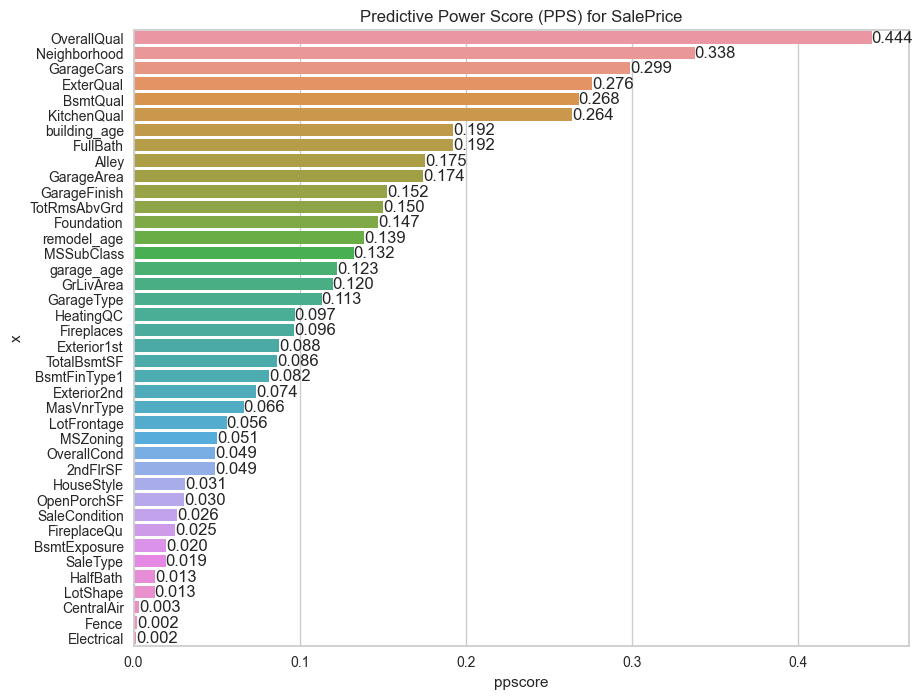

In [26]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(data=pps_predictors.loc[lambda dfr: dfr.ppscore > 0], y="x", x="ppscore", orient="h")
ax.set_title(F"Predictive Power Score (PPS) for {TARGET_NAME}")

# add the annotation
ax.bar_label(ax.containers[-1], fmt='%.3f', label_type='edge');

# Modeling

## Pipeline

![mlflow-tracking](https://mlflow.org/docs/latest/_images/quickstart_tracking_overview.png)

In [27]:
from typing import Union, Dict, Any


def eval_metrics(y_actual: Union[pd.DataFrame, pd.Series, np.ndarray],
                 y_pred: Union[pd.DataFrame, pd.Series, np.ndarray]
                 ) -> Dict[str, float]:
    """Compute evaluation metrics.

    Args:
        y_actual: Ground truth (correct) target values
        y_pred: Estimated target values.

    Returns:
        Dict[str, float]: dictionary of evaluation metrics.
            Expected keys are: "rmse", "mae", "mape", "r2", "max_error"

    """
    # Calculate Root mean squared error, named rmse
    rmse = root_mean_squared_error(y_actual, y_pred)
    # Calculate mean absolute error, named mae
    mae = mean_absolute_error(y_actual, y_pred)
    # Mean absolute percentage error (MAPE)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    # Calculate R-squared: coefficient of determination, named r2
    r2 = r2_score(y_actual, y_pred)
    # Calculate max error: maximum value of absolute error (y_actual - y_pred), named maxerror
    maxerror = max_error(y_actual, y_pred)
    return {"rmse": rmse,
            "mae": mae,
            "mape": mape,
            "r2": r2,
            "max_error": maxerror
           }

In [28]:
def define_pipeline(numerical_transformer: list,
                    categorical_transformer: list,
                    estimator: Pipeline,
                    target_transformer: bool=False,
                    **kwargs: dict) -> Pipeline:
    """Define pipeline for modeling.

    Args:
        numerical_transformer:
        categorical_transformer:
        target_transformer:
        estimator:
        kwargs:

    Returns:
        Pipeline: sklearn pipeline
    """
    numerical_transformer = make_pipeline(*numerical_transformer)

    categorical_transformer = make_pipeline(*categorical_transformer)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, make_column_selector(dtype_include=["number"])),
            ("cat", categorical_transformer, make_column_selector(dtype_include=["object", "bool"])),
        ],
        remainder="drop",  # non-specified columns are dropped
        verbose_feature_names_out=False,  # will not prefix any feature names with the name of the transformer
    )
    # Append regressor to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    if target_transformer:
        model_pipe1 = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("estimator", estimator)])
        model_pipe = TransformedTargetRegressor(regressor=model_pipe1,
                                                func=np.log,
                                                inverse_func=np.exp)
    
    
    else:
        model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("estimator", estimator)])
        
    # logger.info(f"{model_pipe}")
    return model_pipe

## Train / Test split

In [29]:
# Séparer les données en train et test (25%)

FEATURES = FEATURE_NAMES if any(FEATURE_NAMES) else MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]

x_train, x_test, y_train, y_test = train_test_split(data.loc[:, FEATURES],
                                                    data[TARGET_NAME],
                                                    test_size=MODEL_PARAMS["TEST_SIZE"],
                                                    random_state=SEED
                                                   )

logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

2024-06-29 09:03:34.400 | INFO     | __main__:<module>:11 - 
X train: (1095, 18)
Y train: (1095,)
X test: (365, 18)
Y test: (365,)


## Baseline

In [30]:
# Model definition
reg = define_pipeline(numerical_transformer=[SimpleImputer(strategy="median"),
                                             RobustScaler()],
                      categorical_transformer=[SimpleImputer(strategy="constant", fill_value="undefined"),
                                               OneHotEncoder(drop="if_binary", handle_unknown="ignore")],
                      target_transformer=False,
                      estimator=RandomForestRegressor(n_estimators=30)
                 )

reg

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('robustscaler',
                                                                   Robust...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error',
                                       max_depth=None, max_features=1.0,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       monotonic_cst=None, n_estimators=30,
                                       n_jobs=None, oob_score=False,
                                       random_state=None, verbose=0,
                                       warm_start=False))],
         verbose=False)

### Training

In [31]:
# model training and selection

reg.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 keep_empty_features=False,
                                                                                 missing_values=nan,
                                                                                 strategy='median')),
                                                                  ('robustscaler',
                                                                   Robust...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='squared_error',
                                       max_depth=None, max_features=1.0,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       monotonic_cst=None, n_estimators=30,
                                       n_jobs=None, oob_score=False,
                                       random_state=None, verbose=0,
                                       warm_start=False))],
         verbose=False)

### Model evaluation

In [32]:
# evaluate trained model: sur le train et le test set

# Calcule the evaluation metrics
y_train_pred = reg.predict(x_train)
y_test_pred = reg.predict(x_test)
train_metrics = eval_metrics(y_train, y_train_pred)
test_metrics = eval_metrics(y_test, y_test_pred)

# log out metrics
logger.info(f"""Performances\n{pd.DataFrame({"train": train_metrics, "test": test_metrics}).T}""")

2024-06-29 09:03:36.069 | INFO     | __main__:<module>:10 - Performances
               rmse           mae      mape        r2      max_error
train  12569.569110   7766.107093  0.045221  0.973978  104582.733333
test   29351.406028  19217.903014  0.117304  0.877021  186643.166667


#### Residuals analysis

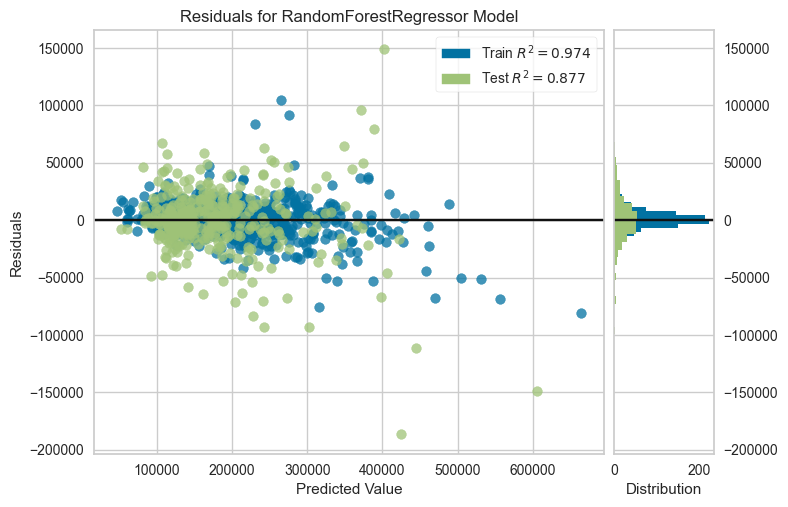

In [33]:
visualizer = ResidualsPlot(reg, is_fitted="auto")

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show();                # Finalize and render the figure

#### Prediction plot

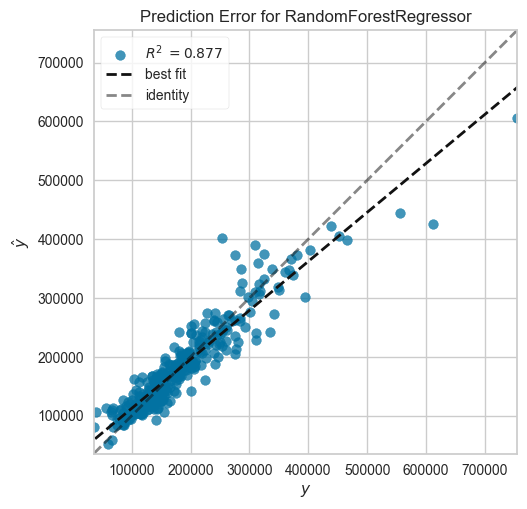

In [34]:
visualizer = PredictionError(reg, is_fitted="auto", bestfit=True, identity=True)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show();                # Finalize and render the figure

### Tester l'un des packages suivants:

__Exo 1__:

1- [PyCaret](https://pycaret.org/): An open source, low-code machine learning library in Python.

2- [LazyPredict](https://pypi.org/project/lazypredict/): Lazy Predict help build a lot of basic models without much code and helps understand which models works better without any parameter tuning


__Exo 2__:

1- Tester la prédiction avec la variable logarithmique


__Exo3__: 
1- Consulter la document de mlflow via les liens précisés au début du notebook



import pycaret.regression as pyr
from lazypredict.Supervised import LazyRegressor


### Tracking

In [55]:
# Create an experiment if not exists
exp_name = "house-price"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id
    
logger.info(f"Experience id: {experiment_id}")

In [66]:
# Define models and parameters to benchmark
ESTIMATOR_PARAMS = {DummyRegressor.__name__: {"estimator": DummyRegressor,
                                              "params": {"strategy": "median"}
                                             },
                    RandomForestRegressor.__name__: {"estimator": RandomForestRegressor,
                                                     "params": {"n_estimators": 30,
                                                                "max_depth": 3,
                                                                "random_state": SEED
                                                               }
                                             },
                    GradientBoostingRegressor.__name__: {"estimator": GradientBoostingRegressor,
                                                         "params": {"n_estimators": 30,
                                                                    "learning_rate": 0.01,
                                                                    "max_depth": 3,
                                                                    "random_state": SEED
                                                                   }
                                                        }
}

ESTIMATOR_PARAMS

{'DummyRegressor': {'estimator': sklearn.dummy.DummyRegressor,
  'params': {'strategy': 'median'}},
 'RandomForestRegressor': {'estimator': sklearn.ensemble._forest.RandomForestRegressor,
  'params': {'n_estimators': 30, 'max_depth': 3, 'random_state': 42}},
 'GradientBoostingRegressor': {'estimator': sklearn.ensemble._gb.GradientBoostingRegressor,
  'params': {'n_estimators': 30,
   'learning_rate': 0.01,
   'max_depth': 3,
   'random_state': 42}}}

In [68]:
for model_name, model_configs in ESTIMATOR_PARAMS.items():
    logger.info(f"{model_name} \n{model_configs}")
    
    estimator = model_configs["estimator"]
    params = model_configs["params"]
    
    # Useful for multiple runs (only doing one run in this sample notebook)
    with mlflow.start_run(run_name=f"{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}-house_price-{model_name}",
                          experiment_id=experiment_id,
                          tags={"version": "v1", "priority": "P1"},
                          description="house price modeling",
                         ) as mlf_run:
        logger.info(f"run_id: {mlf_run.info.run_id}")
        logger.info(f"version tag value: {mlf_run.data.tags.get('version')} -------------------------------")

        # log parameters
        mlflow.log_params(params)
        
        
        # Model definition
        reg = define_pipeline(numerical_transformer=[SimpleImputer(strategy="median"),
                                                     RobustScaler()],
                              categorical_transformer=[SimpleImputer(strategy="constant", fill_value="undefined"),
                                                       OneHotEncoder(drop="if_binary", handle_unknown="ignore")],
                              target_transformer=False,
                              estimator=estimator(**params)
                         )

        reg.fit(x_train, y_train)

        # Evaluate Metrics
        y_train_pred = reg.predict(x_train)
        y_test_pred = reg.predict(x_test)
        train_metrics = eval_metrics(y_train, y_train_pred)
        test_metrics = eval_metrics(y_test, y_test_pred)
        
        # log out metrics
        logger.info(f"Train: {train_metrics}")
        logger.info(f"Test: {test_metrics}")

        # Infer model signature with a sample
        predictions = reg.predict(x_train[:30])
        signature = mlflow.models.infer_signature(x_train[:30], predictions)

        # Log  metrics, and model to MLflow
        mlflow.log_metrics(test_metrics)
        mlflow.sklearn.log_model(reg,
                                 artifact_path=reg[-1].__class__.__name__,
                                 signature=signature,
                                 input_example=x_train[:30])

2024-06-29 09:59:30.090 | INFO     | __main__:<module>:2 - DummyRegressor 
 {'estimator': <class 'sklearn.dummy.DummyRegressor'>, 'params': {'strategy': 'median'}}
2024-06-29 09:59:30.125 | INFO     | __main__:<module>:13 - run_id: eaac7647bbbc474e817da046cdd17daa
2024-06-29 09:59:30.126 | INFO     | __main__:<module>:14 - version tag value: v1 -------------------------------
2024-06-29 09:59:30.154 | INFO     | __main__:<module>:38 - Train: {'rmse': 79691.56579791993, 'mae': 54997.128767123286, 'mape': 0.3141138555411282, 'r2': -0.04600231455138637, 'max_error': 580000.0}
2024-06-29 09:59:30.156 | INFO     | __main__:<module>:39 - Test: {'rmse': 84787.11740440257, 'mae': 57217.32054794521, 'mape': 0.34216649182831993, 'r2': -0.026201017547874184, 'max_error': 590000.0}
2024-06-29 09:59:33.319 | INFO     | __main__:<module>:2 - RandomForestRegressor 
 {'estimator': <class 'sklearn.ensemble._forest.RandomForestRegressor'>, 'params': {'n_estimators': 30, 'max_depth': 3, 'random_state': 4


Tester les modèles suivants:
    
    - DummyRegressor
    - Regression ridge
    - Bosting ou autre modèle ensembliste
    
30 mins

### Performance analysis

### Features importances

### Save model

## Hyperparameters tuning

## Session info

In [36]:
import session_info

In [38]:
session_info.show(dependencies=False)